In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
chunks_range = range(SEQ_LEN-1, EPISODE_LEN, SEQ_LEN)

In [12]:
run_paths = glob.glob("/home/beans/blender_membank/*/run*", recursive=True)

In [13]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in chunks_range], axis=0)
maps = np.concatenate([np.load(f'{run_path}/maps_{i}.npy') for i in chunks_range], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct
#maps[:-1,:,:,:] = maps[1:,:,:,:]

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, maps.shape, run_path

((1160, 12),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 (1160, 120, 80, 3),
 '/home/beans/blender_membank/dataloader_06/run_20')

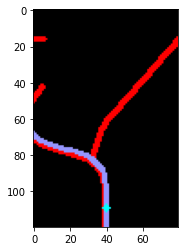

In [14]:
plt.imshow(maps[550])

In [15]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

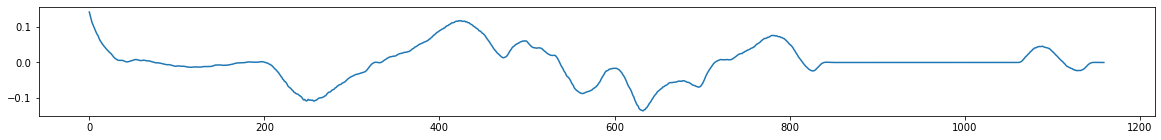

In [16]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

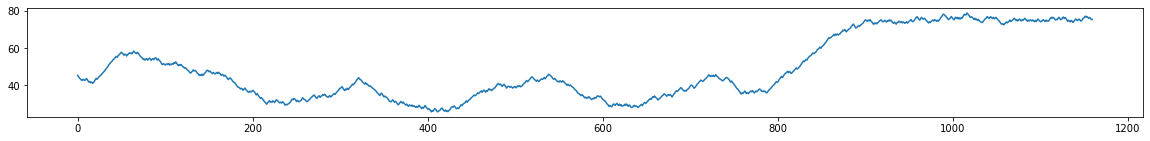

In [17]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [18]:
ix = 1000

In [19]:
t = smooth_near_wps(targets[ix])

In [20]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [21]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

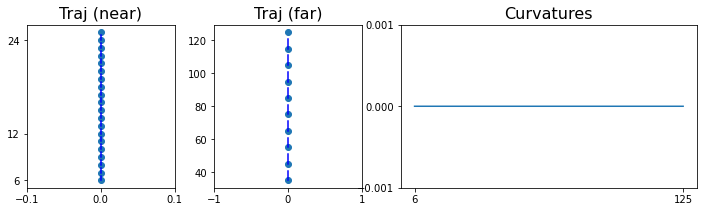

In [22]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

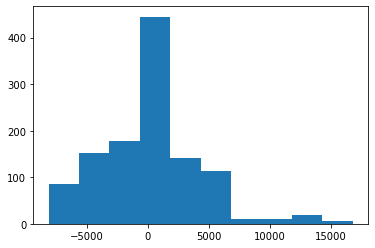

In [23]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

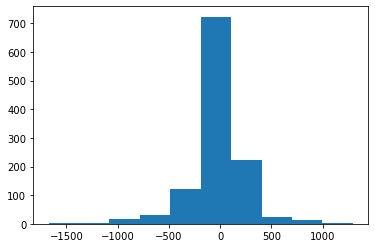

In [24]:
plt.hist(torque[1:]-torque[:-1])[2]

In [25]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [51]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    img[:,-MAP_WIDTH:,:] = maps[i]
    
    video.write(img)
    
video.release()

In [43]:
aux_model, aux_calib, aux_targets = get_auxs(pad(aux))

In [44]:
aux_model.shape, aux_calib.shape, aux_targets.shape

((1, 1160, 5), (1, 1160, 4), (1, 1160, 12))

In [46]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)

for i in range(len(imgs)):
    imgs[i,:,-MAP_WIDTH:,:] = maps[i]

aux_vid = aux.copy()
#aux_vid[:,:2] = 0 # zeroing out pitch and yaw

run_id = "sim"
model_stem = "11.16_avg"
rollout_data = make_vid(run_id, 
                        model_stem, 
                        imgs, 
                        aux_vid, 
                        targets=targets, 
                        add_charts=False)

(1160, 30) (1160, 1, 15, 80) (1160, 1, 15, 80)
240 690 3


/home/beans/bespoke/viz_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  act_grad = act_grad/m


Made vid!


In [47]:
#combine_vids("8.9_avg", "8.9_avgTrain", "sim")

In [48]:
#p = get_viz_rollout(model_stem, imgs, aux_vid, do_gradcam=False)
#wp_angles_all, wp_headings_all, wp_curvatures_all, _, _, _, _, _ = p

In [49]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

(array([ 262.,  382.,  354.,  193.,  881.,  984., 1261., 1231.,  211.,
          41.]),
 array([-6.6448742e-04, -5.0002674e-04, -3.3556606e-04, -1.7110539e-04,
        -6.6447187e-06,  1.5781596e-04,  3.2227664e-04,  4.8673732e-04,
         6.5119797e-04,  8.1565866e-04,  9.8011934e-04], dtype=float32),
 <BarContainer object of 10 artists>)

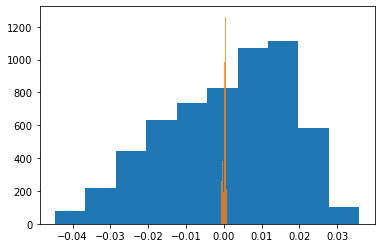

In [50]:
plt.hist(targets[:,:5].flatten())
plt.hist(wp_angles_all[:,:5].flatten(), alpha=.8)

In [22]:
obsnet_outs.shape

(1160, 3)

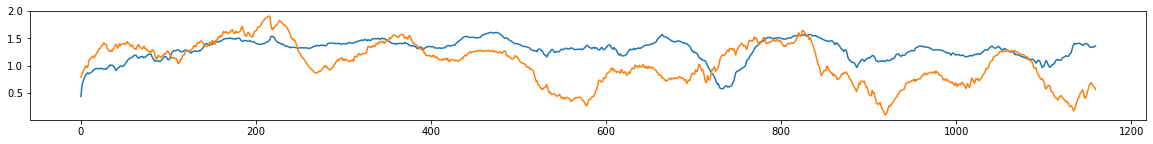

In [23]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])
plt.plot(obsnet_outs[:,2])

In [24]:
aux[0]

array([7.9585475e-01, 1.5869594e+00, 4.5101814e+01, 0.0000000e+00,
       3.2588083e-03], dtype=float32)

In [26]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
all_run_paths = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/home/beans/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in chunks_range]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        all_run_paths.append(run_path)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 29 out of 360 runs


In [27]:
all_aux.shape

(331, 1160, 12)

In [28]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 5.7 s, sys: 0 ns, total: 5.7 s
Wall time: 5.7 s


In [29]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [30]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((331, 1160, 30), (331, 1160, 30), (331, 1160, 30), (331, 1160, 30))

In [31]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .5:
        print(i, m)
        mm += 1

4 0.56598943
234 0.52560884


In [32]:
all_run_paths[80]

'/home/beans/blender_membank/dataloader_02/run_23'

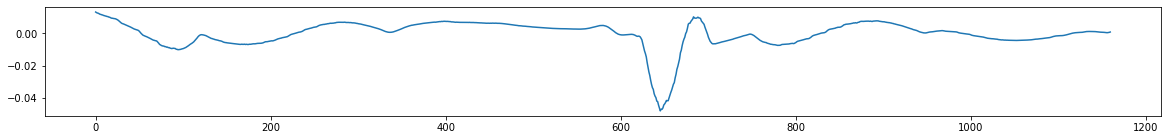

In [33]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[58,:,1])

<BarContainer object of 40 artists>

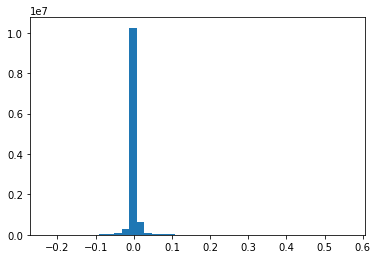

In [34]:
plt.hist(all_curvatures[:,:,:].flatten(), bins=40)[2]

In [35]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

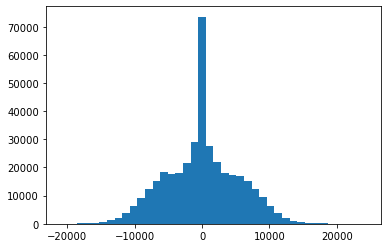

In [36]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

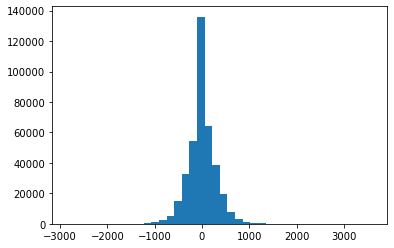

In [37]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [38]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(1316.4414434707353, 18198.605421823842)

In [39]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  6.0007305,   6.999378 ,   7.997499 ,   8.994969 ,   9.991735 ,
        10.9877405,  11.9829645,  12.977374 ,  13.971016 ,  14.963867 ,
        15.955972 ,  16.947351 ,  17.93801  ,  18.92799  ,  19.917345 ,
        20.906027 ,  21.894135 ,  22.88167  ,  23.868656 ,  24.855087 ,
        34.694027 ,  44.49288  ,  54.254658 ,  63.98103  ,  73.674255 ,
        83.33678  ,  92.97122  , 102.58114  , 112.16912  , 121.738    ],
      dtype=float32)

<BarContainer object of 40 artists>

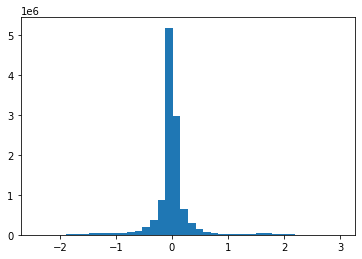

In [40]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [41]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.0379503 , 0.04431767, 0.05080784, 0.05739036, 0.06401458,
       0.0706318 , 0.07720349, 0.08370238, 0.0901107 , 0.09641411,
       0.10260574, 0.10868417, 0.11464348, 0.12047962, 0.12619193,
       0.13178042, 0.13724816, 0.14259785, 0.14783533, 0.15267883,
       0.19688283, 0.23580898, 0.268863  , 0.29679838, 0.3202156 ,
       0.3397612 , 0.3561247 , 0.36962026, 0.38069353, 0.38660923],
      dtype=float32)

In [42]:
mean_headings[-1] / mean_headings[0]

10.18725

In [43]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01846944, 0.02165635, 0.0248476 , 0.02805083, 0.03126772,
       0.03449646, 0.03773209, 0.04096962, 0.04420362, 0.04742901,
       0.05064074, 0.05383451, 0.05700608, 0.06015244, 0.06327049,
       0.0663582 , 0.06941357, 0.07243484, 0.07542124, 0.07837272,
       0.10594606, 0.13021493, 0.15165794, 0.17065522, 0.18745299,
       0.20227627, 0.21534432, 0.22688709, 0.23710385, 0.24615887],
      dtype=float32)

In [44]:
mean_angles[-1] / mean_angles[0]

13.327904

In [45]:
mean_angles[0] / .015

1.23129573961099

<BarContainer object of 40 artists>

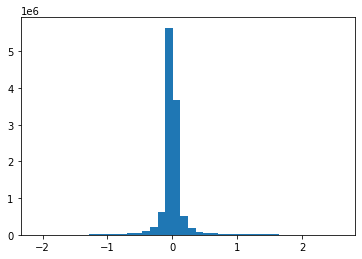

In [46]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

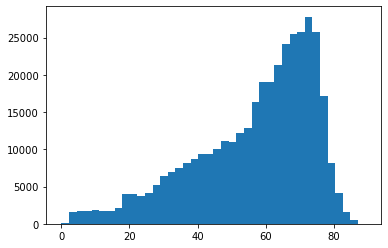

In [47]:
# speed
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

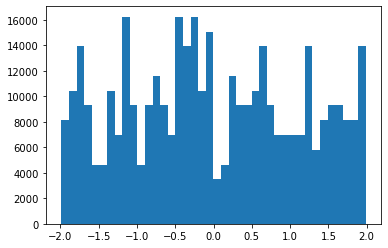

In [48]:
# pitch
plt.hist(all_aux[:,:,0].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

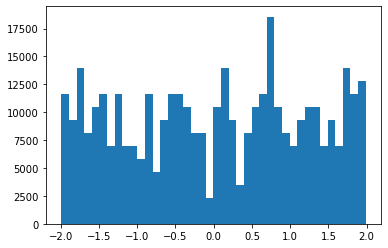

In [49]:
# yaw
plt.hist(all_aux[:,:,1].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

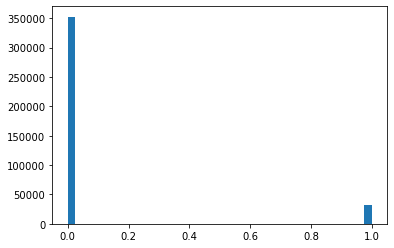

In [50]:
# approaching stop
plt.hist(all_aux[:,:,AUX_APPROACHING_STOP_IX].flatten(), bins=40)[2]

In [51]:
all_aux.shape

(331, 1160, 12)

<BarContainer object of 40 artists>

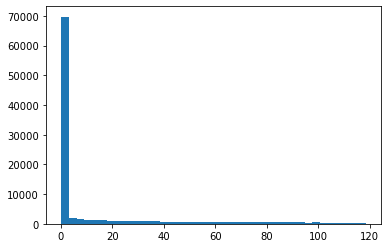

In [52]:
# stop dist
a = all_aux[:,:,AUX_STOP_DIST_IX].flatten()
a = a[a<1e6]
plt.hist(a, bins=40)[2]

<BarContainer object of 40 artists>

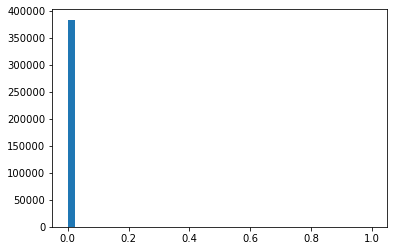

In [53]:
# stopped
a = all_aux[:,:,AUX_STOPPED_IX].flatten()
plt.hist(a, bins=40)[2]

In [54]:
a.sum()

61.0

<BarContainer object of 40 artists>

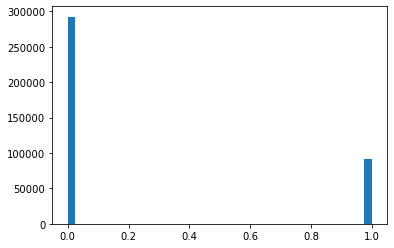

In [55]:
# lead car
a = all_aux[:,:,AUX_HAS_LEAD_IX].flatten()
plt.hist(a, bins=40)[2]

<BarContainer object of 40 artists>

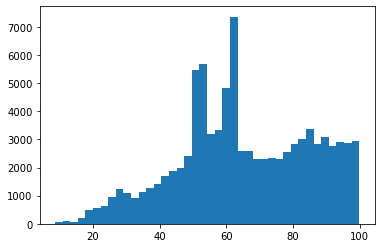

In [56]:
# lead dist
a = all_aux[:,:,AUX_LEAD_DIST_IX].flatten()
a = a[a<1e6]
plt.hist(a, bins=40)[2]

In [59]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/episode_info.npy", recursive=True)
is_just_straight = np.array([np.load(p)[0] for p in paths])
is_just_straight.sum() / len(is_just_straight)

0.2099125364431487